# CS 445 Final Project : Reinforcement Learning with Flappy Bird

*by Cole Juracek. Credit to Chuck Anderson for the general algorithm and information from lecture slides, as well as Stack Overflow for general Python/Pygame questions.*

## IMPORTANT NOTE

I cannot seem to get the game to display within the notebook. All of the code for the game is provided, however, and can be run outside of the notebook.

## Introduction and Motivation

The general goal of this project is two-fold:
1. Code a Flappy Bird type game through Python
2. Control the box's movement through reinforcment learning to teach it to go through the gap in the walls.
    
I have always wanted to code some sort of game in Python, and Pygame was the natural choice. It's fairly intuitive, and didn't take as long as I would have thought to code the game. In addition to this, I've thought the concept of reinforcement learning was very interesting. So to learn how to play a game based off nothing more than states, actions, and reinforcements seemed like a great choice for a final project.

## The Game

The game itself will be familiar to anyone who has played Flappy Bird before. The goal is to get the box through the gap between the two scrolling walls. Collision with either the walls or the floor will result in a game over.

Implementation of the game was fairly simple, although it took a little while to learn Pygame's API. First, the game is initialized and the boilerplate code is handled. The game is advanced frame-by-frame at a rate of 30FPS. At each frame, the walls scroll forward, and new walls are initialized when these reach the end of the screen. The box's motion is handled by `box.py`, which uses equations for projectile motion to handle gravity. If at any point the space bar is pressed, the box will "jump".

* Again, the game will run without being displayed. Because of this, it will "crash" almost immediately due to falling down and hitting the floor. Copy out of the notebook to actually play.

In [1]:
import random
import pygame

from flappy_bird import box, game_constants

def play_game():

    pygame.init()

    game_display = pygame.display.set_mode((game_constants.DISPLAY_WIDTH, game_constants.DISPLAY_HEIGHT))
    pygame.display.set_caption('Flappy Bird')
    clock = pygame.time.Clock()

    flappy_box = box.Box(game_constants.DISPLAY_WIDTH * 0.25, game_constants.DISPLAY_HEIGHT * 0.25)

    delta_x = -15
    wall_x_positions = [x for x in range(game_constants.DISPLAY_WIDTH, 0, delta_x)]
    current_wall_position = 0
    top_wall_lengths = [x for x in range(50, 260, 30)]
    bottom_wall_lengths = [x for x in range(260, 50, -30)]
    index = random.randint(0, len(top_wall_lengths) - 1)
    top_wall_length, bottom_wall_length = top_wall_lengths[index], bottom_wall_lengths[index]

    score = 0
    while True:
        for event in pygame.event.get():
            # If space down, make the box jump
            if event.type == pygame.KEYDOWN and event.key == pygame.K_SPACE:
                flappy_box.jump()

        game_display.fill(game_constants.WHITE)

        # Draw the floor
        floor = pygame.draw.rect(game_display, game_constants.BLACK, pygame.Rect((0, game_constants.DISPLAY_HEIGHT * 0.92),
                                                                  (game_constants.DISPLAY_WIDTH, 50)))

        # Draw the walls
        top_wall = pygame.Rect((wall_x_positions[current_wall_position], 0), (20, top_wall_length))
        top_wall = pygame.draw.rect(game_display, game_constants.BLACK, top_wall)

        bottom_wall_start = game_constants.DISPLAY_HEIGHT - floor.height - bottom_wall_length  # Top of bottom wall
        bottom_wall = pygame.Rect((wall_x_positions[current_wall_position], bottom_wall_start), (20, bottom_wall_length))
        bottom_wall = pygame.draw.rect(game_display, game_constants.BLACK, bottom_wall)

        # Update flappy box
        flappy_box.update_position(game_display)
        flappy_box.increment_time()

        # Check for collision with floor + walls
        collision_surfaces = [floor, top_wall, bottom_wall]
        for collision_surface in collision_surfaces:
            if flappy_box.rect.colliderect(collision_surface):
                pygame.quit()
                print(f'GAME OVER. SCORE: {score}')

        # If walls at end of screen, create new walls
        current_wall_position += 1
        if current_wall_position > len(wall_x_positions) - 1:
            index = random.randint(0, len(top_wall_lengths) - 1)
            top_wall_length, bottom_wall_length = top_wall_lengths[index], bottom_wall_lengths[index]

        current_wall_position = current_wall_position % len(wall_x_positions)

        # Update graphics + advance 1 frame
        pygame.display.update()
        clock.tick(game_constants.FRAMES_PER_SECOND)
        score += 1

pygame 2.5.2 (SDL 2.28.3, Python 3.11.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
play_game()

GAME OVER. SCORE: 39


error: video system not initialized

A brief note: there will be some relaxed constraints on the game such that the reinforcement learning problem is simpler. Namely, the walls will not appear in random positions, but rather in one fixed position.

## Reinforcement Learning: An Overview

The general premise of reinforcement learning is to "reward" an agent with reinforcements for positive moves toward a goal. This is accomplished via 3 key components:
1. *state*: any information necessary to represent the agent's current state
2. *actions*: the set of available actions for the agent in a given state
3. *reinforcement*: represents how well received the current (state, action) pair is

Ideally, the agent would like to pick the action from a given state with the highest reinforcement. But not only should the agent account for the immediate future, it should also account for future states down the line. Because of this, the agent should pick a move based off of the summation of all returns from the future states. This function that predicts the sum of future reinforcements is known as the *Q-function*, and utilizing it in reinforcement learning is known as *Q-Learning*. The general idea is for the agent to examine all of the Q-values for its (state, action) pairs, and pick the move with the highest value.

We would like to update the Q-values to be more accurate over time as the agent explores the problem. There are two main approaches to this. The first is known as *Monte-Carlo*, where Q(state, action) is updated through the average over many trials. Another approach, and the one used for this project, updates Q(state, action) via the next state, action, and reinforcement in a process known as *temporal difference*:

Finally, we run into the dilema of exploration vs. exploitation in reinforcement learning. This problem is stated as the following: should the agent attempt to learn as much as possible about the environment to fill its Q-table (exploration)? Or should the agent only pick the "greedy" action (the one with the highest Q-value) from each state (exploitation)? This issue is resolved by the epsilon parameter. During each iteration, decay epsilon by multiplying it by some fraction (epsilon "decay"). The lower epsilon becomes, the more likely the agent is to pick the greedy option. In effect, this will cause the agent to move from a policy of exploration toward exploitation over the course of its journey.

## Reinforcement Learning Applied to Flappy Bird

For the game of flappy bird, we will define the state as the y-position, and the actions as {0, 1}, corresponding to not jumping and jumping respectively. The reinforcement will more or less be negligible except for the case when the box is colliding with a wall or floor. In this case, the reinforcement for the (state, action) pair will be assigned as low as possible; this corresponds to a game over and is the only real issue we're trying to avoid. If we note the agent is in the gap between the two walls, we will also provide a *positive* reinforcement.

There is no end state in this game; collisions with the floor and walls will not stop it. Each frame will be considered a new "iteration", and the box will move from exploration to exploitation over the course of around 1 minute. 

The default parameters to the game are as follows:
- *epsilon*: 1.0 (standard)
- *epsilon_decay*: 0.999
    - While this might seem like a high value, it is being applied every frame, so epsilon will still decay in a reasonable time.
    
    
- *learning_rate*: 0.8
    - This is how much "weight" we should give to the previous Q-value based off the current temporal difference formula. A value of 1.0 will simply be the formula itself. We will choose a default of slightly less.

Games will be run for a length of two minutes, and the position of the box will be recorded on each frame. There is no means for the game stopping, so interrupting the kernel is necessary; the results will still be saved in 'y_positions'.

In [6]:
import random
import pygame
import sys

from flappy_bird import box, game_constants

moves = []
y_positions = []

In [13]:
def learn_game(epsilon_decay=0.999, learning_rate=0.8, reinf_function=None):
    pygame.init()

    game_display = pygame.display.set_mode((game_constants.DISPLAY_WIDTH, game_constants.DISPLAY_HEIGHT))
    pygame.display.set_caption('Flappy Bird')
    clock = pygame.time.Clock()

    flappy_box = box.Box(game_constants.DISPLAY_WIDTH * 0.25, game_constants.DISPLAY_HEIGHT * 0.5)

    delta_x = -15
    wall_x_positions = [x for x in range(game_constants.DISPLAY_WIDTH, 0, delta_x)]
    current_wall_position = 0

    Q = {}  # Lookup table for Q-values
    epsilon = 1.0
    valid_moves = [0, 1]  # Where 0 = Do nothing
                          #       1 = Jump
    state = flappy_box.y_pos

    # Return a new move
    def make_move(state, move):
        if move == 1:
            flappy_box.jump()

        # Update flappy box
        flappy_box.update_position(game_display)
        flappy_box.increment_time()

        return flappy_box.y_pos

    num_moves = 0
    epsilon_counter = 0
    
    while True:
        for event in pygame.event.get():
            x = 4

        game_display.fill(game_constants.WHITE)
        # Draw the floor
        floor = pygame.draw.rect(game_display, game_constants.BLACK, pygame.Rect((0, game_constants.DISPLAY_HEIGHT * 0.92),
                                                                  (game_constants.DISPLAY_WIDTH, 50)))
        # Draw the walls
        top_wall = pygame.Rect((wall_x_positions[current_wall_position], 0), (20, 150))
        top_wall = pygame.draw.rect(game_display, game_constants.BLACK, top_wall)
        bottom_wall = pygame.Rect((wall_x_positions[current_wall_position], 350), (20, 250))
        bottom_wall = pygame.draw.rect(game_display, game_constants.BLACK, bottom_wall)

        # TODO: Consider default value; might want to make very positive vs. very negative
        # Pick a move
        epsilon *= epsilon_decay
        if random.uniform(0, 1) < epsilon:  # Random move
            move = random.choice(valid_moves)
        else:  # Greedy move
            q_values = [Q.get((state, action), -100) for action in valid_moves]
            move = valid_moves[q_values.index(max(q_values))]

        new_state = make_move(state, move)

        # TODO: Consider different default value
        # If (state, move) tuple does not exist, add it to Q-table
        if (state, move) not in Q:
            Q[(state, move)] = -100

        # Check for collision with floor + walls
        # If there is a collision, we should assign with as much negative reinforcement as possible, as this would
        #   be a game over.
        collision_surfaces = [floor, top_wall, bottom_wall]
        if any([flappy_box.rect.colliderect(surface) for surface in collision_surfaces])
            Q[(state, move)] = -sys.maxsize
        # elif 200 <= state <= 300 and -10 <= flappy_box.y_velocity <= 10:
            # Q[(state, move)] = sys.maxsize
        # elif state == 0:
            # Q[(state, move)] = -sys.maxsize
        elif 225 <= state <= 275 and 175 <= top_wall.center[0] <= 225:
            Q[(state, move)] = 100

        # If walls at end of screen, create new walls
        current_wall_position += 1
        current_wall_position = current_wall_position % len(wall_x_positions)

        # Update graphics + advance 1 frame
        pygame.display.update()
        clock.tick(game_constants.FRAMES_PER_SECOND)

        # TODO: Consider adding reinforcement
        # Update Q-table of the old (state, move) tuple by calculating the temporal difference error.
        # Reinforcement of -1
        if num_moves > 1 and reinf_function is None:
            Q[(old_state, old_move)] += (learning_rate * (Q[state, move] - Q[(old_state, old_move)]))
        elif num_moves > 1 and reinf_function is not None:
            Q[(old_state, old_move)] += (learning_rate * (reinf_function(state, flappy_box) + Q[state, move] - Q[(old_state, old_move)]))
            
        # Update moves + states for next move
        old_state, old_move = state, move
        state = new_state
        num_moves += 1

        if epsilon_counter % 100 == 0:
            print(f'Epsilon: {epsilon}')
        y_positions.append(state)

        epsilon_counter += 1

In [14]:
learn_game()

Epsilon:  0.999
Epsilon:  0.9038873549665959
Epsilon:  0.8178301806491574
Epsilon:  0.7399663251239436


KeyboardInterrupt: 

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

375


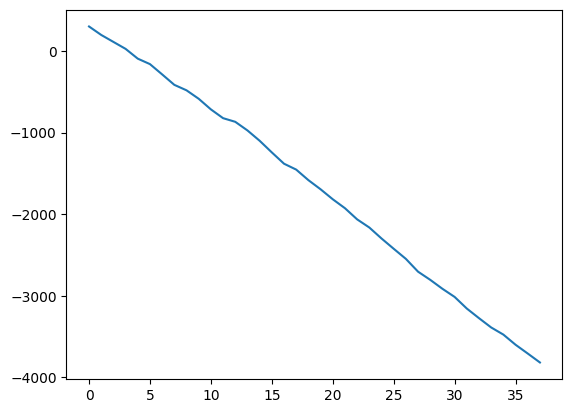

In [17]:
plt.plot(y_positions[0::10])
print(len(y_positions))

We can definitely see an improvement over time. Ideally, we want to be around 250, as this is the middle of the gap between the two walls. Toward the beginning, the box is at 0 (top of the screen) the majority of the time, as multiple '0' actions are required to fall, while only one '1' action (jump) is needed to push back toward the top of the screen. However, the box eventually learns that multiple falling actions might be a good to escape the ceiling and head toward the gap.

## Tweaking Parameters

There are only two real parameters to change here: the learning rate and epsilon decay. We'll try two radically different values for both, one higher and one lower, and examine the results.

### Changing epsilon decay

In [ ]:
y_positions = []
learn_game(epsilon_decay=0.99) # Epsilon decays much quicker

Epsilon:  0.99
Epsilon:  0.36237201786049694
Epsilon:  0.13263987810938213
Epsilon:  0.0485504851305729


In [ ]:
plt.plot(y_positions[0::10])
plt.title('Positions over time with epsilon = 0.99')

As expected, this epsilon decay value brought epsilon down too quickly. The box seemed to learn that hugging the top of the screen wasn't optimal, but it very infrequently came between the gap in the wall. This is presumably because it didn't explore enough.

In [ ]:
y_positions = []
epsilon_decay = 0.9999
learn_game(epsilon_decay=0.9999) # Epsilon decays much slower

In [ ]:
plt.plot(y_positions[0::10])
plt.title(f'Positions over time with epsilon = {epsilon_decay}')

At 2 minutes, epsilon was not able to decay to a value even close to 0. Because of this, it was frequently picking a random move even at the end, which more often than not caused the box to stay toward the top of the screen. This result could be interesting however; let's pick an epsilon in the middle and increase the time to 5 minutes:

In [ ]:
y_positions = []
epsilon_decay = 0.9995
learn_game(epsilon_decay=epsilon_decay) # Epsilon decays a bit slower

In [ ]:
plt.plot(y_positions[0::10])
plt.title(f'Positions over time with epsilon = {epsilon_decay}')

Toward the very end, the agent seemed to be performing at its best compared to other epsilon values. However, we did also train this for 5 minutes vs. 2 minutes. If anything, this just shows that longer training times might be necessary for optimal results.

### Changing the learning rate

I don't expect changing the learning rate will have as big of an effect as changing the epsilon decay, as the Q-values being altered are very large. However, we will see:

In [ ]:
y_positions = []
learning_rate = 0.3
learn_game(learning_rate=learning_rate) # Learn less from the immediate future

In [ ]:
plt.plot(y_positions[0::10])
plt.title(f'Positions over time with learning rate = {learning_rate}')

Contrary to my prediction, this actually seemed to have a substantial effect, as we can see from the graph. The box tended to hover around 250 a good amount of time toward the end.

In [ ]:
y_positions = []
learning_rate = 1.3
learn_game(learning_rate=learning_rate) # "Learn" more from the immediate future

In [ ]:
plt.plot(y_positions[0::10])
plt.title(f'Positions over time with learning rate = {learning_rate}')

This learning rate seemed to make the agent perform much worse. It was giving too much weight in the temporal difference formula. We do not see the agent come close to converging even after two minutes.

### Adding a Reinforcement Function

Previously, we were not that concerned with what the box was doing when it was far away from the walls; we only cared about what happened when it was immediately around the walls. However, a simple reinforcement function might help the box stay near the center, such that it might converge quicker on good Q-values:

In [ ]:
# If the box is in the top half of the screen, favor positive velocities
# Else, it's in the bottom half, so we should favor negative velocities
def reinforcement2(state, box):
    if state > 250:  # Bottom half, favor negative velocities
        return box.y_velocity * -1
    else:  # Top half
        return box.y_velocity

One might think that reinforcing based off of position would be a simple idea. However, this turned out to be more complicated than initially thought. If the box is in the top half and travelling on an upward arc, a move of 0 (doing nothing) would be desired. Yet all the algorithm would see is a "nothing" move that moved the box upward. Because of this, favorable moves might be given bad values, so velocity was chosen instead.

In [ ]:
y_positions = []
learn_game(reinf_function=reinforcement2)

In [ ]:
plt.plot(y_positions[0::10])
plt.title('Positions over time with velocity reinforcement function')

Overall, adding the reinforcement function caused our agent to perform the best. We can see a definitive progression toward 250. But most importantly, once the agent learned this was a good place to be, it didn't seem to regress back toward constantly hugging the top.

## Results

The two parameters seemed to have a large effect on the performance of the agent, although the default parameters performed at an acceptable level. The default value of epsilon seemed to perform best at the two minute mark, although I have little doubt that epsilon = 0.9999 would outclass this given noticeably longer times (10+ minutes). The agent also seemed to respond well to a lower-than-default learning rate, where the Q-values were updated in a less extreme manner. Finally, the simple reinforcement function I've implemented seemed to help more than not, and gave the agent an idea for where to aim even when near no walls.

## Conclusion and Challenges Faced

Overall, I would say the assignment was a success. It was a great way to apply machine learning concepts to a relevant example. It taught me how to look for such abstract concepts as "state" and "action" when they weren't explicitly defined.

The main challenge of the assignment was not the machine learning; it was working with Pygame. I've never coded a game in it before, so I wasn't really sure how to translate my thoughts to code. Luckily, Pygame has good documentation and the common questions that I needed had been answered before. Moving to the machine learning side, the main issue I faced was debugging. When the game wasn't working as desired, it was hard to tell if it was my fault in the game logic, the algorithm, or how I had defined Q-learning. The only real means I had of examining it was to watch the game unfold on screen.

Moving forward, I would like to get the reinforcement learning working with random walls, and perhaps implement a better reinforcement function such that the solution might converge faster.